# TransUNet Inference Demo on Fundus Datasets

This notebook demonstrates how to load the test set, load a trained TransUNet model, run inference on a sample, and visualize the results.

In [1]:
# python -m ipykernel install \
#   --user \
#   --name venv \
#   --display-name "Python (venv)"

In [2]:
# Imports
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import random

# Ensure current directory is in python path to handle local imports
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

try:
    from datasets.dataset_drive import Drive_dataset
    from datasets.dataset_chasedb import ChaseDB_dataset
    from datasets.dataset_hrf import HRF_dataset
    from networks.vit_seg_modeling import VisionTransformer as ViT_seg
    from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
    print("Successfully imported project modules.")
except ImportError as e:
    print(f"Error importing modules: {e}")
    print("Make sure you are running this notebook from './TransUNet'")

Successfully imported project modules.


In [29]:
# Configuration
class Args:
    def __init__(self, dataset: str):
        # Dataset Configuration
        self.dataset = dataset
        self.volume_path = "data/" + dataset
        self.num_classes = 2
        self.img_size = 224
        
        # Model Configuration
        self.vit_name = "R50-ViT-B_16" 
        self.n_skip = 3
        self.vit_patches_size = 16
        
        # Checkpoint Path
        # Example: "model/TU_DRIVE224/TU_pretrain_R50-ViT-B_16_skip3_epo150_bs24_224/best_model.pth"
        self.model_path = f"model/TU_{dataset}{self.img_size}/TU_pretrain_{self.vit_name}_skip{self.n_skip}_epo1000_bs1_lr0.005_{self.img_size}/best_model.pth"

args = Args("CHASEDB")
print(f"Configuration:\n Dataset: {args.dataset}\n Data Path: {args.volume_path}\n Model Config: {args.vit_name}")

Configuration:
 Dataset: CHASEDB
 Data Path: data/CHASEDB
 Model Config: R50-ViT-B_16


In [30]:
# Load DRIVE Test Set
try:
    db_test = ChaseDB_dataset(base_dir=args.volume_path, split="test")
    testloader = DataLoader(db_test, batch_size=1, shuffle=False)
    print(f"Test dataset loaded successfully. Total samples: {len(db_test)}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please check 'volume_path' and ensure the data exists.")

Test dataset loaded successfully. Total samples: 20


In [31]:
# Initialize Model
def get_model(args):
    config_vit = CONFIGS_ViT_seg[args.vit_name]
    config_vit.n_classes = args.num_classes
    config_vit.n_skip = args.n_skip
    if args.vit_name.find('R50') != -1:
        config_vit.patches.grid = (int(args.img_size / args.vit_patches_size), int(args.img_size / args.vit_patches_size))
    
    net = ViT_seg(config_vit, img_size=args.img_size, num_classes=config_vit.n_classes)
    return net

model = get_model(args)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model initialized on {device}.")

# Load Weights
if os.path.exists(args.model_path):
    try:
        model.load_state_dict(torch.load(args.model_path, map_location=device))
        print(f"Loaded weights from {args.model_path}")
    except Exception as e:
        print(f"Error loading weights: {e}")
else:
    print(f"WARNING: Checkpoint not found at {args.model_path}")
    print("Proceeding with random weights for demonstration purposes.")

model.eval();

Model initialized on cuda.
Loaded weights from model/TU_CHASEDB224/TU_pretrain_R50-ViT-B_16_skip3_epo1000_bs1_lr0.005_224/best_model.pth


In [32]:
# Inference and Visualization Function
def visualize_prediction(idx=None):
    if idx is None:
        idx = random.randint(0, len(db_test)-1)
    
    print(f"Visualizing sample index: {idx}")
    
    sample = db_test[idx]
    image = sample['image'] # (C, H, W)
    label = sample['label'] # (H, W)
    case_name = sample['case_name']
    
    input_image = image.unsqueeze(0).to(device) # (1, C, H, W)
    
    with torch.no_grad():
        output = model(input_image)
        # Apply softmax and get class index
        pred = torch.argmax(torch.softmax(output, dim=1), dim=1).squeeze(0).cpu().numpy()
        
    # Convert image for display (C, H, W) -> (H, W, C)
    img_vis = image.permute(1, 2, 0).numpy()
    
    # Normalize image for display (min-max normalization)
    if img_vis.max() > img_vis.min():
        img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min())
        
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_vis)
    axes[0].set_title(f"Input Image ({case_name})")
    axes[0].axis('off')
    
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    
    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title("Prediction")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [33]:
i = 0

Visualizing sample index: 1


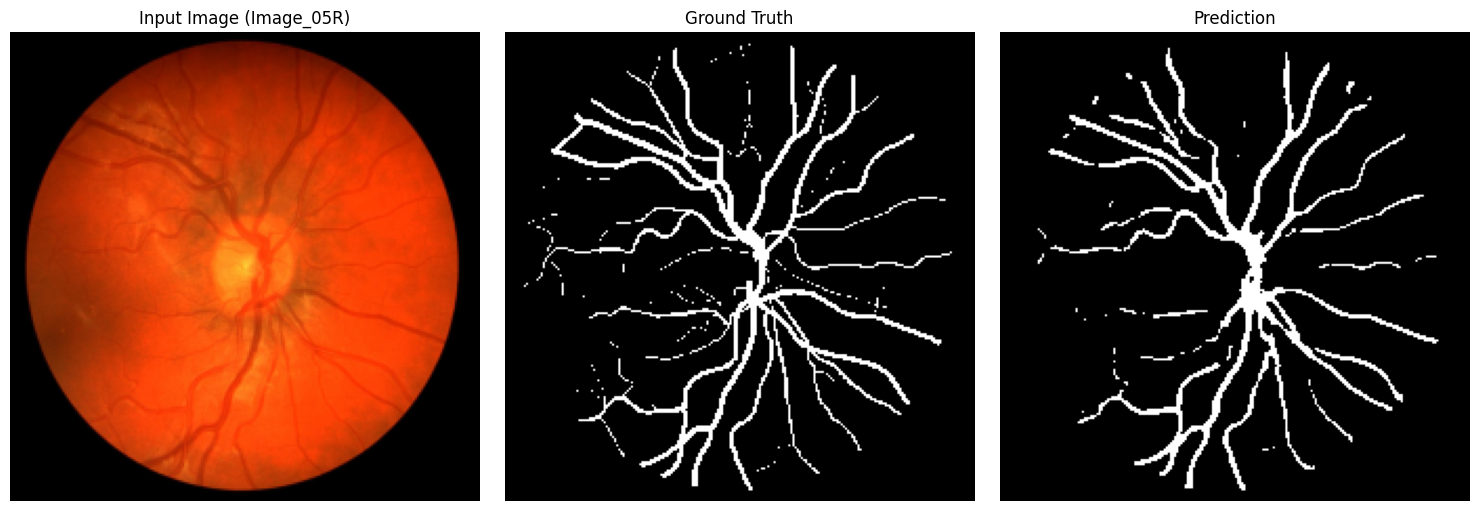

In [35]:
# Run Visualization
if i < len(db_test):
    visualize_prediction(i)
    i += 1